In [2]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from example.discretizer.discretizer import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
import math
from typing import Tuple

from example.dataset.utils import determine_travel_alignment, create_semi_circle, create_semi_ellipse, create_rectangle
import matplotlib.pyplot as plt

In [3]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')


#DATAROOT_pics = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#MINI
nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 33.993 seconds.
Reverse indexing ...
Done reverse indexing in 6.2 seconds.


In [4]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'yaw_rate': 'float64'}
df = pd.read_csv(DATAROOT / 'train_v1.0-trainval_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city ="boston-seaport"#'singapore-onenorth' #'singapore-hollandvillage' # 'boston-seaport' #'boston-seaport'#'singapore-onenorth' boston-seaport'#
df = df[df['location'] == city]
df.head()

,sample_token,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,yaw_rate,acceleration
0,3481dbfd65864925b4a4b2d6b7256d44,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:29.048702,"[0.27668389210179944, -0.0026796705507768723, ...",427.968583,1622.155828,0.0,2.580930,0.000004,0.000033,0.000000
1,394d87634b6c46049c2f06e84026096a,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:29.548597,"[0.27667585323668453, -0.002728894247491543, 0...",427.968582,1622.155829,0.0,2.580947,0.000004,0.000033,0.000000
2,656b4207ba9542b2a9bb7c03aa61b325,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.048445,"[0.2766247744031405, -0.0027369692279543625, 0...",427.968589,1622.155824,0.0,2.581053,0.000018,0.000212,0.000028
3,2f789ae558a84df9b8daee0674a7985f,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.548859,"[0.27663215946727443, -0.002737971665731827, 0...",427.968593,1622.155822,0.0,2.581038,0.000008,-0.000031,-0.000020
4,623e58c15be546b39a36796a5b03d18f,0053e9c440a94c1b84bd9c4223efc4b0,0.178096,boston-seaport,lidar,2018-07-27 16:20:31.048731,"[0.27662503731230986, -0.002729398219646146, 0...",427.968591,1622.155823,0.0,2.581052,0.000004,0.000029,-0.000008


Fit PG

In [5]:
env = SelfDrivingEnvironment(city)
disc = AVDiscretizerD1(env)
pg = PG.PolicyGraph(env, disc)
#pg = pg.fit(df, update=False, verbose=True)

Render

In [6]:
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)

In [7]:
#scene_test = 'c5224b9b454b4ded9b5d2d2634bbda8a' #df['scene_token'].unique()[0] 
#example_scene_df = df[df['scene_token']==scene_test]

/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


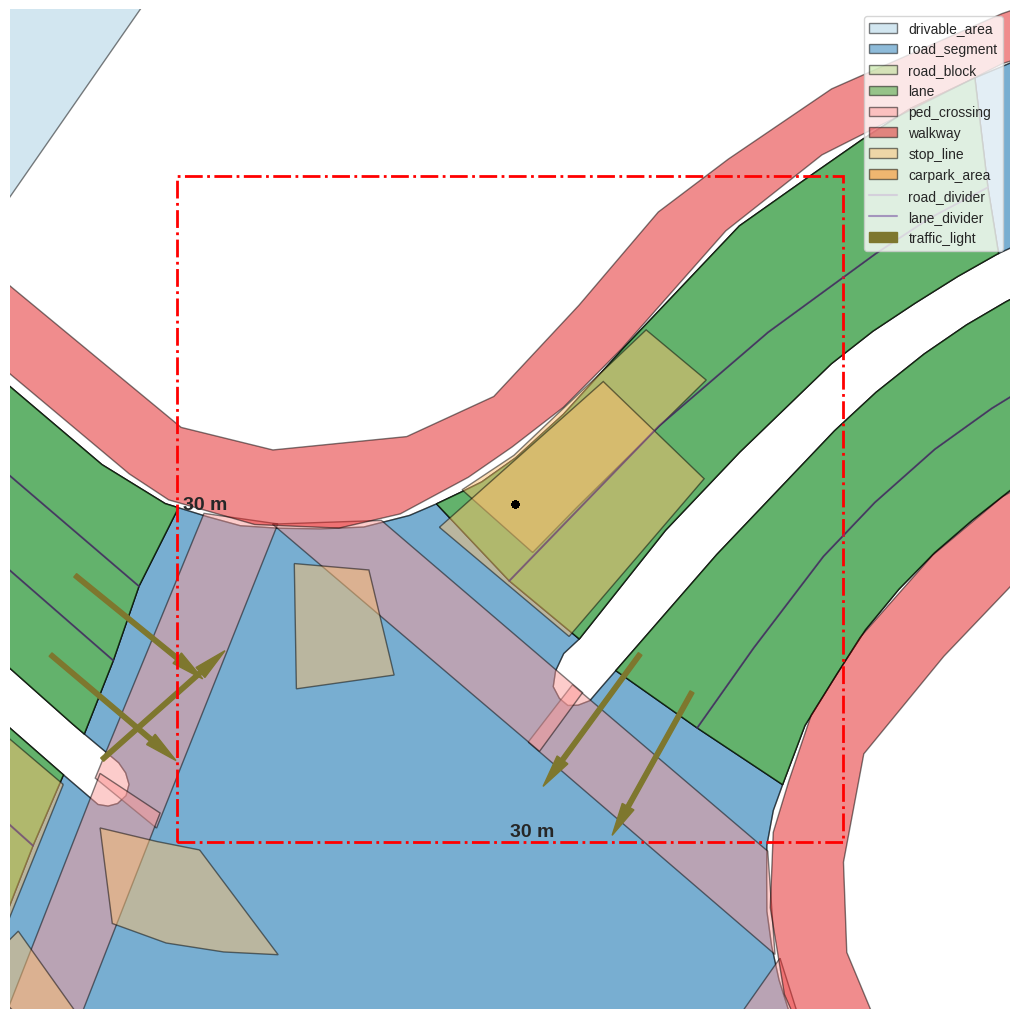

In [8]:

ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=['19f47b8941094af29b8db20b255717fc'], verbose=False)


## Position Predicates

In [8]:
#nuscenes.render_scene(scene_test)

#### Lane Progress Predicate

In [9]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']==scene]
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        
        x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
        
        lane_predicates = env.get_lane_info(x,y, yaw, eps=0.3, agent_size=(2,4))
        print(lane_predicates)
        if False:########
            #PLOT
            ########
            
            #render agent as a renctangle and show its heading direction compare to the direction of the lane
            #for each sample in the scene.
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            current_lane = nusc_map.record_on_point(x,y, 'lane')

            if road_segment_token and nusc_map.get('road_segment', road_segment_token)['is_intersection'] and not current_lane:
                closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
                lane_path = nusc_map.get_arcline_path(closest_lane)
                closest_pose_idx_to_lane, lane_record, _ = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane_path)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                    tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

            else:

                lane = nusc_map.get_arcline_path(current_lane)
                closest_pose_idx_to_lane, lane_record, distance_along_lane = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                        tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

    
              
            patch_size = 20
            patch_box = [x,y, patch_size, patch_size]
            patch = NuScenesMapExplorer.get_patch_coord(patch_box)
            minx, miny, maxx, maxy = patch.bounds

            fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
            
            #ax.add_patch(Rectangle((x, y), agent_size[0], agent_size[1], yaw))
            ax.scatter(x,y)
            heading_vector = np.array([np.cos(yaw), np.sin(yaw)])

            yaw =  math.degrees(-(math.pi / 2) + yaw)
            rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
            ax.quiver(x, y, heading_vector[0], heading_vector[1], color='b', scale=10, label='Ego Direction')
            ax.quiver(x,y, tangent_vector[0], tangent_vector[1],  color='r', scale=10, label='Lane Direction')
            x,y = rotated_rectangle.exterior.xy
            ax.plot(x,y)
            ax.set_title(lane_predicates)
            
    print('-------------------------')

SCENE 0053e9c440a94c1b84bd9c4223efc4b0


NameError: name 'create_rotated_rectangle' is not defined

In [ ]:
for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    yaw =  math.degrees(-(math.pi / 2) + yaw)
    if True:#is_on_divider(x,y,yaw, (2,4), ['road_divider', 'lane_divider']) in [True]:

         #for visual confirmation
        patch_size = 20
        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
        
        ax.scatter(x,y)

        rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y)
    
        plt.title(f'Plot for index {i}')
        plt.show()


# Proximity Predicates

#### Traffic Light Predicate

In [25]:
from shapely.geometry import Point, Polygon

def is_near_traffic_light(yaw, front_area:Polygon, eps=0.1):
        """
        Check if there is a traffic light nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.
            yaw (float): Yaw angle of the vehicle in radians.
            front_area (Polygon): area for detecting traffic light.
            eps (float): Epsilon value for alignment tolerance

        Returns:
            bool: True if a traffic light is nearby and aligned with the vehicle's direction of travel, False otherwise.
            (TODO return dict: Information about the nearby traffic light (if any))
        
        """

        
        for traffic_light in nusc_map.traffic_light:
                line = nusc_map.extract_line(traffic_light['line_token'])
                xs, ys = line.xy
                point = Point(xs[0], ys[0])# Traffic light is represented as a line, we take the starting point
                
                if point.within(front_area):
                    
                    traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])   
                    alignment = determine_travel_alignment(traffic_light_direction, yaw)
                    print(f'traffic light alignmenet {alignment}')
                    if alignment <-eps:
                        print('valid traffic light')
                        return True
        
        for stop_line in nusc_map.stop_line:
            if stop_line['stop_line_type'] == 'TRAFFIC_LIGHT':
                    stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])
                    if stop_line_polygon.intersects(front_area):
                        if stop_line['traffic_light_tokens']:
                            for token in stop_line['traffic_light_tokens']:
                                traffic_light = nusc_map.get('traffic_light', token)
                                print(traffic_light)
                                line = nusc_map.extract_line(traffic_light['line_token'])
                                xs, ys = line.xy
                                point = Point(xs[0], ys[0])# Traffic light is represented as a line, we take the starting point
                                
                                if point.within(front_area):
                                    
                                    traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])   
                                    alignment = determine_travel_alignment(traffic_light_direction, yaw)
                                    print(f'traffic light alignmenet {alignment}')
                                    if alignment <-eps:
                                        print('valid traffic light stop line')
                                        return True

        return False




#### Stop Sign Predicate

In [13]:
def is_near_stop_sign(x,y, front_area:Polygon):
        """
        Check if there is a stop sign or yield nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.
            yaw (float): Yaw angle of the vehicle in radians.

        Returns:
            bool: True if a sign is nearby the ego car and in the same road block, False otherwise.
        
        """        

        current_road_block = nusc_map.record_on_point(x,y, 'road_block')
        #print(f'current road block {current_road_block}')


        for stop_line in nusc_map.stop_line:
            if stop_line['stop_line_type'] in ['STOP_SIGN','YIELD']:
                    stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])                
                    if stop_line_polygon.intersects(front_area):
                        print(f'a sign is intersecting{stop_line}')

                        if stop_line['road_block_token'] == current_road_block or current_road_block == '': #or intersection
                                return True
                
        return False



#### Pedestrian Crossing Predicate

In [14]:
def is_near_ped_crossing(front_area:Polygon):
    
    #current_road_block = nusc_map.record_on_point(x,y, 'road_block')
    #print(f'current road block {current_road_block}')
    #current_road_segment = nusc_map.record_on_point(x,y, 'road_segment')
    #print(f'current road segment {current_road_segment}')

        
    for ped_crossing in nusc_map.ped_crossing:  
        ped_crossing_polygon = nusc_map.extract_polygon(ped_crossing['polygon_token'])
        if ped_crossing_polygon.intersects(front_area):
            print('zebra nearby')
            return True

    for stop_line in nusc_map.stop_line:
        if stop_line['stop_line_type'] == 'TURN_STOP':
                stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])
                if stop_line_polygon.intersects(front_area):
                    if stop_line['ped_crossing_tokens']:
                            #for token in stop_line['ped_crossing_tokens']:
                                #ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                                #print(f'ped_crossing road segment {ped_cross_road_segment}')
                                #if ped_cross_road_segment == current_road_segment: #TODO what if road_segment is none
                                    print('zebra nearby (turn stop)')
                                    return True 
                    else:
                        print('turn stop (no zebra)') #TODO:
        return False

    


scene: 0053e9c440a94c1b84bd9c4223efc4b0


/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


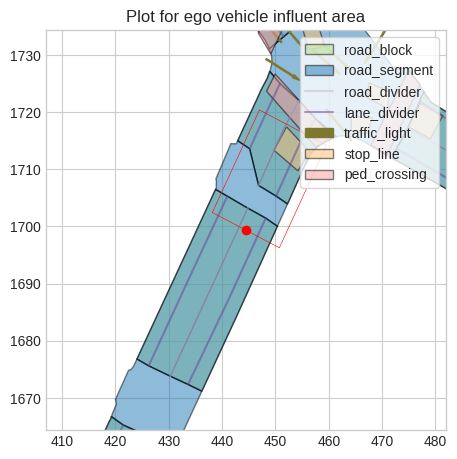

zebra nearby
hello
RECTANGLE: zebra True, traffic False, stop sign False


/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


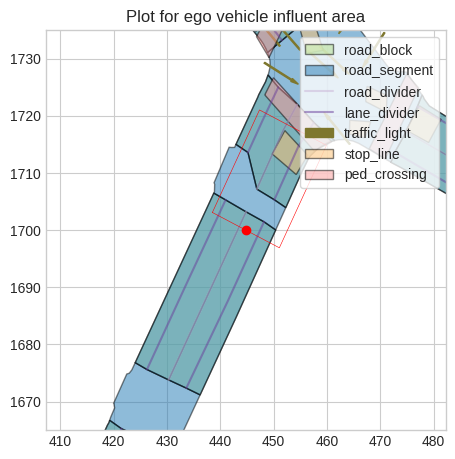

zebra nearby
hello
RECTANGLE: zebra True, traffic False, stop sign False


IndexError: single positional indexer is out-of-bounds

In [26]:
shape = 'rectangle'
for scene in df['scene_token'].unique():
    print(f'scene: {scene}')
    #nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=[scene], verbose=False)

    example_scene_df = df[df['scene_token']=='35ecd252b8ee4cbc83376148e192a803']
    for i in range(38,41):#range(example_scene_df.shape[0]):
        x,y,yaw = example_scene_df.iloc[i][['x','y','yaw']].tolist()
        # Create a rotated rectangle around the vehicle's current pose
        yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
        #front_area = create_rectangle((x,y), yaw_in_deg, size=(15,20), shift_distance=10) if shape == 'rectangle' else create_semi_circle(yaw_in_deg, radius=8)
        front_area = create_rectangle((x,y),yaw_in_deg, size=(14,20), shift_distance=10)
        env.render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape=shape)

        lane_predicate = is_near_ped_crossing(front_area)
        traffic_predicate = is_near_traffic_light( yaw, front_area)
        sign_predicate = is_near_stop_sign( x,y,front_area)
        
        print(f'RECTANGLE: zebra {lane_predicate}, traffic {traffic_predicate}, stop sign {sign_predicate}')
        

        #front_area = create_rectangle((x,y),yaw,size = (14,20), shift_distance=10)
        #env.render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape=shape, radius=(7,20))
        '''
        lane_predicate_2= is_near_ped_crossing(front_area)
        traffic_predicate_2 = is_near_traffic_light( yaw, front_area)
        sign_predicate_2 = is_near_stop_sign( x,y,front_area)
        
        if lane_predicate_2 != lane_predicate or traffic_predicate_2!=traffic_predicate or sign_predicate_2!=sign_predicate:
            print(f'ELLIPSE: zebra {lane_predicate}, traffic {traffic_predicate}, stop sign {sign_predicate}')
            env.render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape='semi_ellipse', radius=(7,20))

            print(f'RECTANGLE: zebra {lane_predicate_2}, traffic {traffic_predicate_2}, stop sign {sign_predicate_2}')
            env.render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape='rectangle')

        '''
    break

Save file

In [26]:
import csv
output_file = f'scene_frame_data_{city}.csv'

with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['scene', 'frame', 'zebra', 'traffic', 'stop_sign'])
    
    for scene in df['scene_token'].unique():
        print(f'scene: {scene}')
        
        example_scene_df = df[df['scene_token'] == scene]
        for i in range(example_scene_df.shape[0]):
            x, y, yaw = example_scene_df.iloc[i][['x', 'y', 'yaw']].tolist()
            yaw_in_deg = math.degrees(-(math.pi / 2) + yaw)
            
            # Create a rotated rectangle around the vehicle's current pose
            front_area = create_rectangle((x, y), yaw_in_deg, size=(14, 20), shift_distance=10)

            lane_predicate = is_near_ped_crossing(front_area)
            traffic_predicate = is_near_traffic_light(yaw, front_area)
            sign_predicate = is_near_stop_sign(x, y, front_area)
            
            print(f'RECTANGLE: zebra {lane_predicate}, traffic {traffic_predicate}, stop sign {sign_predicate}')
            
            # Write the values to the CSV file
            writer.writerow([scene, i, lane_predicate, traffic_predicate, sign_predicate])

print(f'Data saved to {output_file}')

scene: 0053e9c440a94c1b84bd9c4223efc4b0
zebra nearby
traffic light alignmenet 0.15776728642041937
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.1577836314267324
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15788846385410377
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15787326850586947
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15788765093375462
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15775576427650373
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15775307692054258
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.1577689201580264
RECTANGLE: zebra True, traffic False, stop sign False
zebra nearby
traffic light alignmenet 0.15815019234322425
RECTANGL

: 

### Test Stop Line Predicate

In [ ]:
from example.discretizer.utils import IsZebraNearby, IsTrafficLightNearby,IsStopSignNearby


In [ ]:
def nearby_stop_lines(x,y,yaw, radius = 8):
    
    render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape ='circle')

    is_sign_nearby = False#IsStopSignNearby.NO
    is_zebra_nearby = False#IsZebraNearby.NO
    is_traffic_light_nearby = False#IsTrafficLightNearby.NO

    yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
    semi_circle = create_semi_circle((x,y), yaw_in_deg, radius)
    #rotated_rectangle = create_rotated_rectangle((x,y), yaw_in_deg, size=(15,19), shift_distance=10)
    
    current_road_block = nusc_map.record_on_point(x,y, 'road_block')
    print(f'current road block {current_road_block}')
    current_road_segment = nusc_map.record_on_point(x,y, 'road_segment')
    print(f'current road segment {current_road_segment}')


    for stop_line in nusc_map.stop_line:
        stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])
        

        if semi_circle.intersects(stop_line_polygon):
            print(stop_line)
            
            if not is_sign_nearby and stop_line['stop_line_type'] in ['STOP_SIGN','YIELD'] and stop_line['road_block_token'] == current_road_block :
                is_sign_nearby = True#IsStopSignNearby.YES
                for token in stop_line['ped_crossing_tokens']:
                    ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                    print(f'ped_crossing road segment {ped_cross_road_segment}')
                    if ped_cross_road_segment == current_road_segment: #NOTE: what is road_segment is none
                        print('zebra nearby. do not know if in my road')
                        is_zebra_nearby = True

                    break
                #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

            if not is_traffic_light_nearby and stop_line['stop_line_type'] == 'TRAFFIC_LIGHT':
                #if stop_line['road_block_token'] == current_road_block or current_road_segment == "": #if same block
                    #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                    for traffic_light_token in stop_line['traffic_light_tokens']:
                        traffic_light = nusc_map.get('traffic_light', traffic_light_token)
                        line_token = traffic_light['line_token']

                        line = nusc_map.extract_line(line_token)

                        xs, ys = line.xy                 
                                
                        traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])
                                
                        alignment = determine_travel_alignment(traffic_light_direction, yaw)
                        eps = 0.5 #explain why not 0.1
                        if alignment <eps:
                            is_traffic_light_nearby = True
                            print(f'traffic light nearby with eps {alignment}')

                            break
                
            if  not is_zebra_nearby and stop_line['stop_line_type'] == 'PED_CROSSING':
                #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                for token in stop_line['ped_crossing_tokens']:
                    ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                    print(f'ped_crossing road segment {ped_cross_road_segment}')
                    if ped_cross_road_segment == current_road_segment: #NOTE: what is road_segment is none
                        print('zebra nearby. do not know if in my road')
                        is_zebra_nearby = True

                    break

            if stop_line['stop_line_type'] == 'TURN_STOP':
                if stop_line['ped_crossing_tokens']:
                    print('turn stop with ped cross')

                    for token in stop_line['ped_crossing_tokens']:
                        ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                        print(f'ped_crossing road segment {ped_cross_road_segment}')
                        if ped_cross_road_segment == current_road_segment: #TODO what if road_segment is none
                            print('zebra nearby. do not know if in my road')
                            is_zebra_nearby = True

                        break
                else:

                    #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                    print('turn stop with no ped cross')
            #    print(f'turn stop info: {stop_line} ')
                

                        
        if is_sign_nearby and  is_zebra_nearby and is_traffic_light_nearby:
           break
        
    return is_sign_nearby, is_zebra_nearby, is_traffic_light_nearby

        


Road segments are None when we have all lanes of the same direction.
 If we are at intersection or when lanes have opposite direction, road segmenet is not None.